In [1]:
import pathlib

import pandas as pd

from pedpy.io.trajectory_loader import load_trajectory, TrajectoryUnit
from pedpy.data.geometry import MeasurementLine, WalkableArea
from pedpy.methods.method_utils import compute_individual_voronoi_polygons, Cutoff
from pedpy.column_identifier import (
    ID_COL,
    FRAME_COL,
    X_COL,
    Y_COL,
    POINT_COL,
    SPECIES_COL,
)

from shapely import Polygon
import matplotlib.pyplot as plt
import numpy as np
from pedpy.plotting.plotting import plot_measurement_setup, plot_density
from pedpy.methods.flow_calculator import separate_species, calc_speed_on_line, calc_density_on_line, calc_flow_on_line
from pedpy.methods.speed_calculator import compute_individual_speed

from tests.utils.utils import get_trajectory
from pedpy.data.trajectory_data import TrajectoryData

In [2]:
pedpy_blue = (89 / 255, 178 / 255, 216 / 255)
pedpy_orange = (220 / 255, 160 / 255, 73 / 255)
pedpy_green = (108 / 255, 190 / 255, 167 / 255)
pedpy_petrol = (98 / 255, 190 / 255, 190 / 255)
pedpy_grey = (114 / 255, 125 / 255, 139 / 255)
pedpy_red = (233 / 255, 117 / 255, 134 / 255)

In [3]:
traj_paths = ("demo-data/bi-directional/bi_corr_400_b_08.txt",
              "demo-data/bottleneck/040_c_56_h-.txt",
              "demo-data/bi-directional/bi_corr_400_b_03.txt", 
              "demo-data/uni-directional/traj_UNI_CORR_500_08.txt",
              "demo-data/uni-directional/traj_UNI_CORR_500_03.txt",
              "get_trajectory()"
              )
selected_traj = traj_paths[2]


if selected_traj == traj_paths[0]:
    # note that agent 637 never touches line
    traj = load_trajectory(
        trajectory_file=pathlib.Path(selected_traj)
    )
    walkable_area = WalkableArea([(-6.0, 0), (5, 0), (5, 4), (-6, 4)])
    measurement_line = MeasurementLine([(0.0, 0.0), (0.0, 4.0)])
    poly1 = Polygon([(-6, 0), (-4, 0), (-4, 4), (-6, 4)])
    poly2 = Polygon([(3, 0), (5, 0), (5, 4), (3, 4)])
elif selected_traj == traj_paths[1]:
    traj = load_trajectory(
        trajectory_file=pathlib.Path(selected_traj)
    )
    poly2 = Polygon([(3.5, -2), (3.5, 8), (-3.5, 8), (-3.5, -2)])
    poly1 = Polygon()
    walkable_area = WalkableArea(
    # complete area
    [(3.5, -2),(3.5, 8),(-3.5, 8),(-3.5, -2),],
    obstacles=[
        # left barrier
        [(-0.7, -1.1),(-0.25, -1.1),(-0.25, -0.15),(-0.4, 0.0),(-2.8, 0.0),(-2.8, 6.7),(-3.05, 6.7),(-3.05, -0.3),(-0.7, -0.3),(-0.7, -1.0),],
        # right barrier
        [(0.25, -1.1),(0.7, -1.1),(0.7, -0.3),(3.05, -0.3),(3.05, 6.7),(2.8, 6.7),(2.8, 0.0),(0.4, 0.0),(0.25, -0.15),(0.25, -1.1),],
    ],)
    
    measurement_line = MeasurementLine([(0.25, 0), (-0.25, 0)])
elif selected_traj == traj_paths[2]:
    traj = load_trajectory(
        trajectory_file=pathlib.Path(selected_traj)
    )
    walkable_area = WalkableArea([(-6.0, -0.5), (5, 0), (5, 4), (-6, 4.5)])
    measurement_line = MeasurementLine([(0.0, 0.0), (0.0, 4.0)])
    poly1 = Polygon([(-6, -0.5), (-4, -0.5), (-4, 4.5), (-6, 4.5)])
    poly2 = Polygon([(3, -0.5), (5, -0.5), (5, 4.5), (3, 4.5)])
elif selected_traj == traj_paths[3]:
    # note there are a lot of agents that never cross the line and have no "correct species"
    traj = load_trajectory(
        trajectory_file=pathlib.Path(selected_traj), default_unit=TrajectoryUnit.METER
    )
    walkable_area = WalkableArea([(-5.5, 0), (5, 0), (5, 5), (-5.5, 5)])
    measurement_line = MeasurementLine([(0.0, 0.0), (0.0, 5)])
    poly1 = Polygon([(-6, 0), (-4, 0), (-4, 5), (-6, 5)])
    poly2 = Polygon([(3, 0), (5, 0), (5, 5), (3, 5)])
elif selected_traj == traj_paths[4]:
    traj = load_trajectory(
        trajectory_file=pathlib.Path(selected_traj), default_unit=TrajectoryUnit.METER
    )
    walkable_area = WalkableArea([(-5.5, 0), (5, 0), (5, 5), (-5.5, 5)])
    measurement_line = MeasurementLine([(0.0, 0.0), (0.0, 5)])
    poly1 = Polygon([(-6, 0), (-4, 0), (-4, 5), (-6, 5)])
    poly2 = Polygon([(3, 0), (5, 0), (5, 5), (3, 5)])
elif selected_traj == traj_paths[5]:
    traj_up =get_trajectory(
                shape=[5, 5],
                number_frames=200,
                start_position=np.array([0, 0]),
                movement_direction=np.array([0, 0.2]),
                ped_distance=2.0,
            )
    traj_down =get_trajectory(
                shape= [5, 5],
                number_frames=200,
                start_position=np.array([1, 40]),
                movement_direction=np.array([0, -0.2]),
                ped_distance=2.0
            )
    traj_down[ID_COL] += 100
    traj = TrajectoryData(
        data=pd.concat([traj_up, traj_down], ignore_index=True),
        frame_rate=10.0
    )
    walkable_area = WalkableArea([(-0.5, -0.5),(10.5, -0.5), (10.5, 50.5), (-0.5, 50.5)])
    measurement_line = MeasurementLine([(-0.5, 25), (10.5, 25)])
    poly1 = Polygon([(-0.5, 35.5),(10.5, 35.5), (10.5, 50.5), (-0.5, 50.5)])
    poly2 = Polygon([(-0.5, -0.5),(10.5, -0.5), (10.5, 15.5), (-0.5, 15.5)])
    
else:
    traj = load_trajectory(
        trajectory_file=pathlib.Path(selected_traj)
    )
    raise f"for the selected traj is no walkable area defined"

In [4]:
individual_cutoff = compute_individual_voronoi_polygons(
    traj_data=traj,
    walkable_area=walkable_area,
    cut_off=Cutoff(radius=0.8, quad_segments=3)
)

In [5]:

individual_speed = compute_individual_speed(
    traj_data=traj,
    frame_step=1,
    compute_velocity=True,
)

species = separate_species(individual_voronoi_polygons=individual_cutoff, measurement_line=measurement_line, frame_step=25, traj=traj)


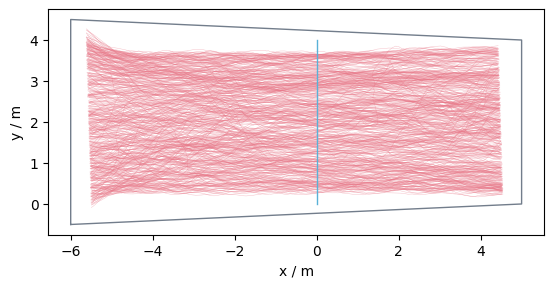

In [6]:
plot_measurement_setup(
    traj=traj,
    walkable_area=walkable_area,
    traj_alpha=0.5,
    traj_width=0.3,
    measurement_lines=[measurement_line],
    ma_line_width=2,
    ma_alpha=0.5,
).set_aspect("equal")

plt.show()

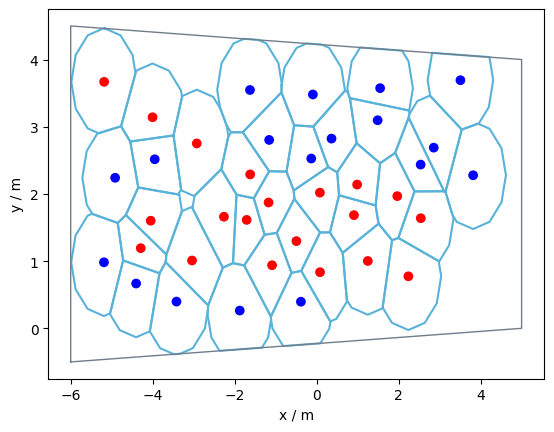

In [7]:
from pedpy.plotting.plotting import plot_voronoi_cells
import numpy as np

frame = 500

plot_voronoi_cells(voronoi_data=individual_cutoff, frame=frame, traj_data=traj, walkable_area=walkable_area)
positions = traj.data.merge(species[[ID_COL, SPECIES_COL]], on=ID_COL, how='left') 

positions['color'] = np.where(positions[SPECIES_COL] == 1, "b", "r")
#positions['color'] = np.where(np.isnan(positions[SPECIES_COL]), "b", "r")
idx = positions[positions[FRAME_COL] == frame]
plt.scatter(idx[X_COL], idx[Y_COL], c=idx["color"])
plt.show()

In [8]:
for frame in range(0, 0, 1):
    plt.clf()
    plot_voronoi_cells(voronoi_data=individual_cutoff, frame=frame, traj_data=traj, walkable_area=walkable_area)
    idx = positions[(positions[FRAME_COL] == frame)]
    plt.scatter(idx[X_COL], idx[Y_COL], c=idx["color"])
    print(frame)
    plt.xlim(-0.5, 10.5)
    plt.ylim(20, 30)
    plt.savefig(f"delete_soon/{frame}_bi.png")


In [9]:
default_linewidth = 1
from pedpy.plotting.plotting import plot_speed_at_line, plot_density_at_line, plot_flow_at_line

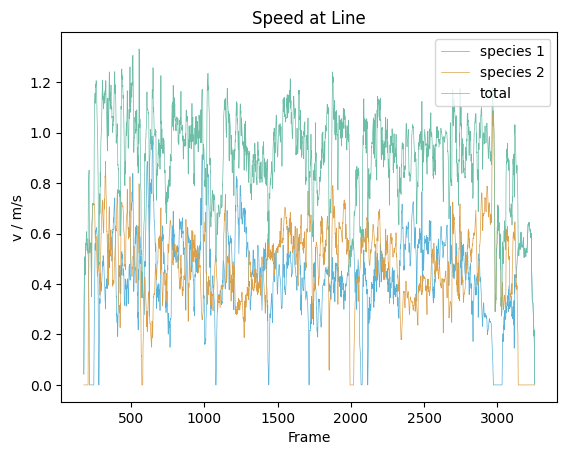

In [10]:
speed_on_line = calc_speed_on_line(individual_voronoi_polygons=individual_cutoff, measurement_line=measurement_line, individual_speed=individual_speed, species=species)
plot_speed_at_line(speed_at_line=speed_on_line)
plt.show()

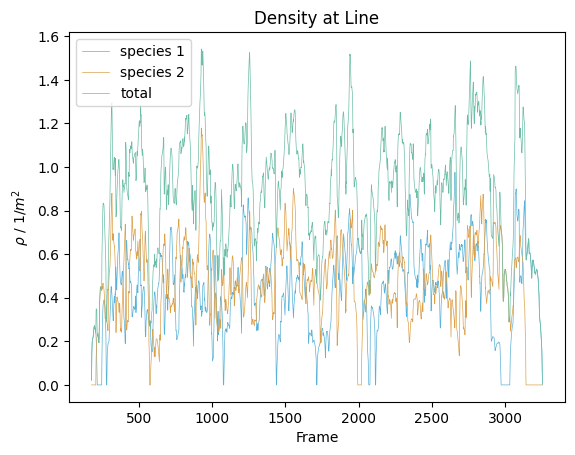

In [11]:
plot_density_at_line(density_at_line=calc_density_on_line(individual_voronoi_polygons=individual_cutoff, measurement_line=measurement_line, species=species))
plt.show()

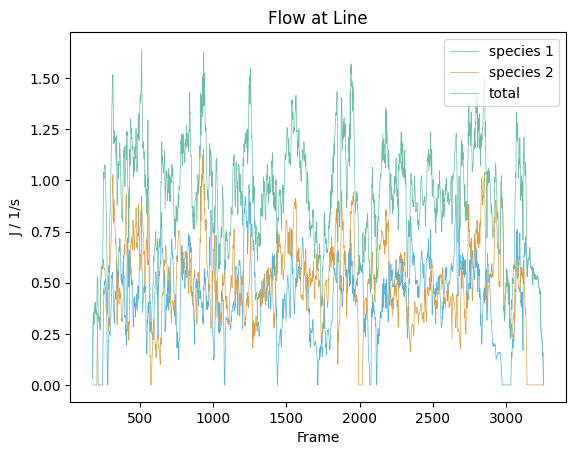

In [12]:
plot_flow_at_line(flow_at_line=calc_flow_on_line(individual_voronoi_polygons=individual_cutoff,measurement_line=measurement_line, individual_speed=individual_speed, species=species))
plt.show()

/home/christian/PycharmProjects/PedPy/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in intersection
  result = getattr(ufunc, method)(*inputs, **kwargs)


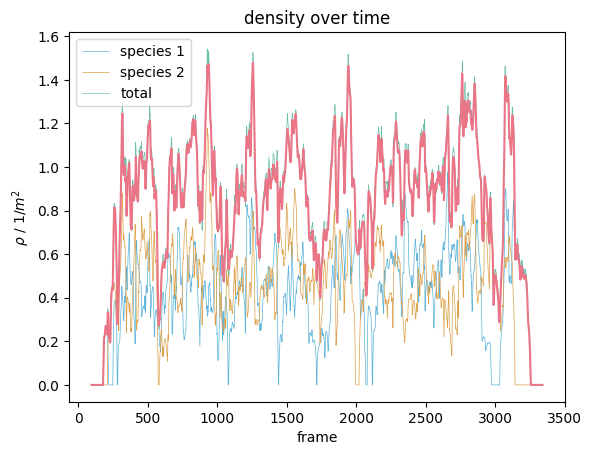

In [13]:
from pedpy.data.geometry import MeasurementArea
from pedpy.methods.density_calculator import compute_voronoi_density
from shapely import Polygon 

temp_line = measurement_line.line.buffer(0.1)
minx, miny, maxx, maxy = temp_line.bounds
polygon = Polygon([(minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny)])
measurement_area = MeasurementArea(polygon)
density_voronoi, intersecting = compute_voronoi_density(
    individual_voronoi_data=individual_cutoff, measurement_area=measurement_area
)

plot_density_at_line(density_at_line=calc_density_on_line(individual_voronoi_polygons=individual_cutoff, measurement_line=measurement_line, species=species))
plot_density(density=density_voronoi, color=pedpy_red)
plt.show()

In [14]:
def expected_species(traj, spawn_1, spawn_2):
    min_idx = traj.data.groupby(ID_COL)[FRAME_COL].idxmin()
    species_here = traj.data.loc[min_idx, [ID_COL, FRAME_COL, POINT_COL]]
    species_here[SPECIES_COL] = species_here.apply(lambda row: calc_species(row[POINT_COL], spawn_1, spawn_2), axis=1)
    return species_here[[ID_COL, SPECIES_COL, FRAME_COL]]

def calc_species(pos, spawn_1: Polygon, spawn_2:Polygon):
    if spawn_1.contains(pos):
        return 1
    if spawn_2.contains(pos):
        return -1
    else:
        return 0
    

In [15]:

expected = expected_species(traj, poly1, poly2)

merged = expected.merge(species, on="id", suffixes=('_expected', '_species'), how="outer")
non_matching = pd.concat([merged[merged['species_expected'] != merged['species_species']], merged[np.isnan(merged['species_species'])]])
print(f"no. non matching elements in species: {non_matching.shape[0]}")

no. non matching elements in species: 0
